# Supermarket Sales

Description:
* 1000 rows, 5 parent and 5 child features

Parent features:
* Branch, City, Customer type, Gender, Product line, Unit price

Child features:
* Quantity, Tax 5%, Total, Date, Time, Payment

Source: https://www.kaggle.com/aungpyaeap/supermarket-sales

In [13]:
import sys
sys.path.append("C:/Users/notes/grab")

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
sm = pd.read_csv("../data/supermarket.csv")

In [16]:
parent = sm[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price']]
parent.head()

,Branch,City,Customer type,Gender,Product line,Unit price
0,A,Yangon,Member,Female,Health and beauty,74.69
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28
2,A,Yangon,Normal,Male,Home and lifestyle,46.33
3,A,Yangon,Member,Male,Health and beauty,58.22
4,A,Yangon,Normal,Male,Sports and travel,86.31


In [17]:
child = sm[['Quantity', 'Tax 5%', 'Total', 'Date', 'Time', 'Payment']]
child.head()

,Quantity,Tax 5%,Total,Date,Time,Payment
0,7,26.1415,548.9715,1/5/2019,13:08,Ewallet
1,5,3.8200,80.2200,3/8/2019,10:29,Cash
2,7,16.2155,340.5255,3/3/2019,13:23,Credit card
3,8,23.2880,489.0480,1/27/2019,20:33,Ewallet
4,7,30.2085,634.3785,2/8/2019,10:37,Ewallet


In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
t_parent = enc.fit_transform(parent[['Branch', 'City', 'Customer type', 'Gender', 'Product line']])

X = np.append(t_parent, parent[['Unit price']], axis=1)

In [19]:
enc = OneHotEncoder(sparse=False)
t_child = enc.fit_transform(child[['Payment']])

child_month = pd.to_datetime(child['Date']).dt.month
child_day = pd.to_datetime(child['Date']).dt.day
child_hour = pd.to_datetime(child['Time']).dt.hour
child_dt = pd.concat([child_month, child_day, child_hour], axis=1).values

y = np.concatenate([child[['Quantity', 'Tax 5%', 'Total']], t_child, child_dt], axis=1)

In [20]:
import tensorflow as tf

X = X.astype(np.float32)
y = y.astype(np.float32)
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(32)

In [26]:
from model.gmm import GMM

# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=1000, plot=True, verbose=True, logdir="gmm_supermarket")
y_hat = gmm.sample(X)

0 [NLL: 1976.2010498046875]
100 [NLL: 23.493566513061523]
200 [NLL: 23.65589714050293]
300 [NLL: 22.6669979095459]
400 [NLL: 22.180561065673828]
500 [NLL: 21.997682571411133]
600 [NLL: 22.02121353149414]
700 [NLL: 21.016359329223633]
800 [NLL: 21.540197372436523]
900 [NLL: 22.003713607788086]


In [25]:
%load_ext tensorboard
%tensorboard --logdir experiments/logs/gmm_supermarket

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 94676), started 0:04:58 ago. (Use '!kill 94676' to kill it.)

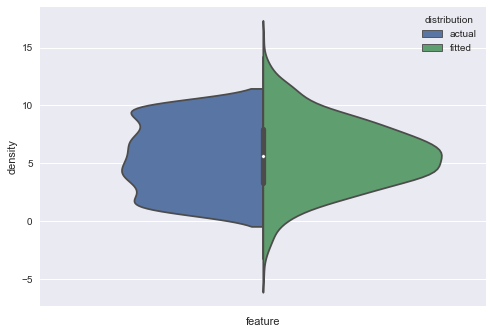

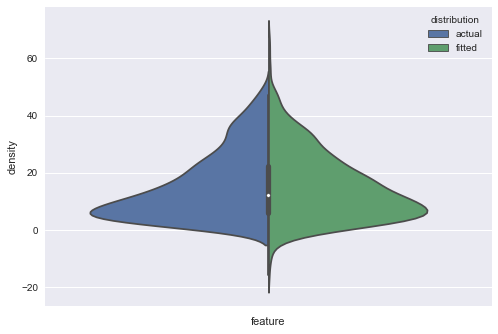

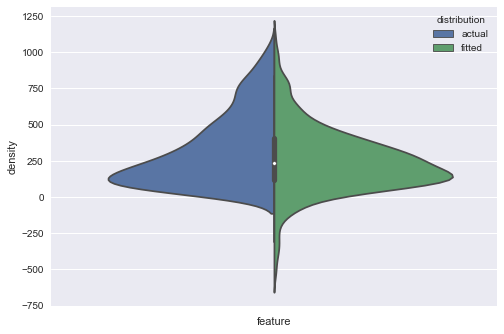

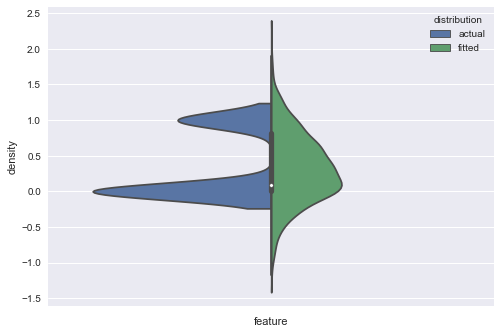

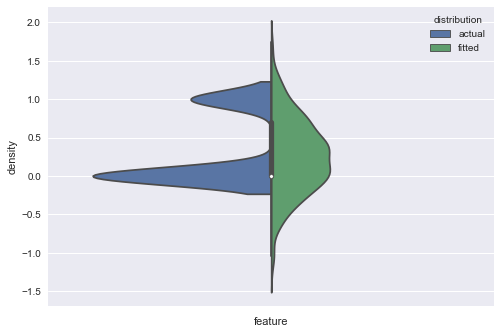

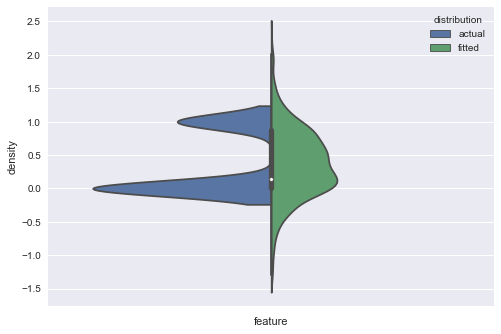

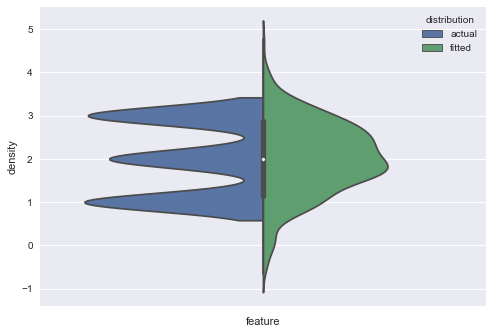

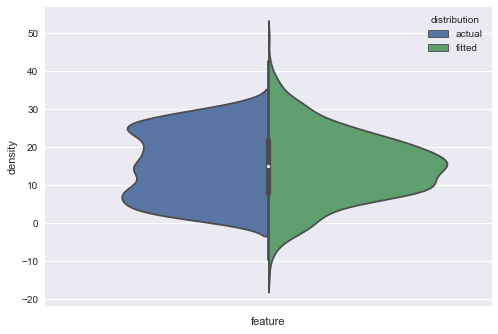

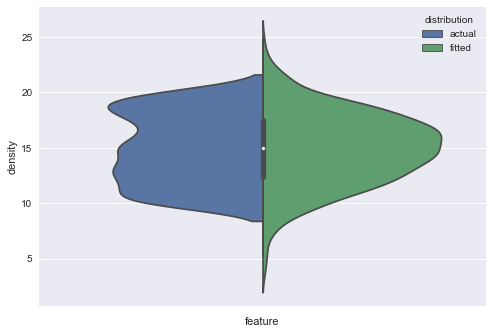

In [27]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [28]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 1.104614220210514
JS: 0.03041833700361188


In [34]:
print("KL:", sum([kl(*prob_overlap(y[:,i], y_hat[:,i], bins=10)) for i in range(y.shape[1])]))
print("JS:", sum([js(*prob_overlap(y[:,i], y_hat[:,i], bins=10)) for i in range(y.shape[1])]))

KL: 8.60731859642898
JS: 0.8064891567572111


In [29]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32)

cgan.fit(dataset, epochs=1000, verbose=True, logdir="cgan_supermarket")

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 16)           528         input_11[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 16)           288         input_12[0][0]                   
____________________________________________________________________________________________

In [10]:
%load_ext tensorboard
%tensorboard --logdir logs/cgan_supermarket

Reusing TensorBoard on port 6006 (pid 4160), started 0:07:19 ago. (Use '!kill 4160' to kill it.)

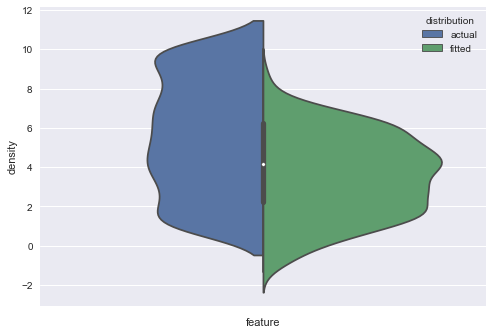

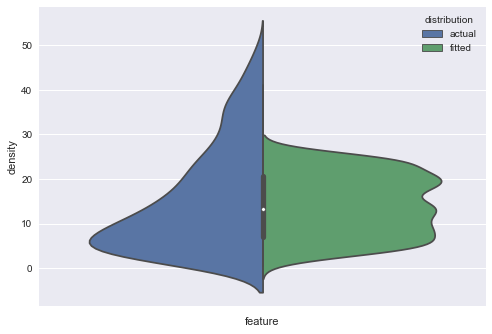

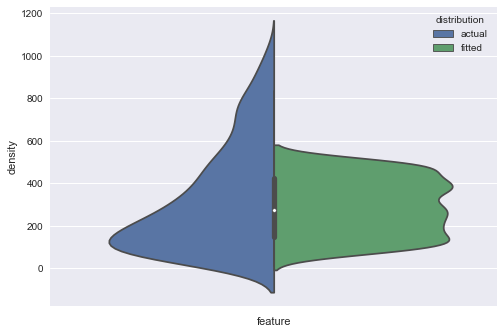

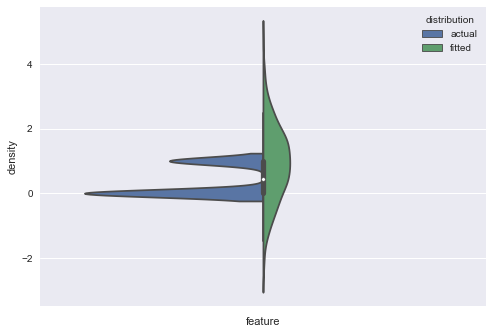

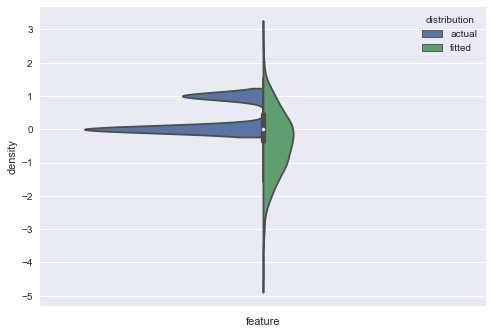

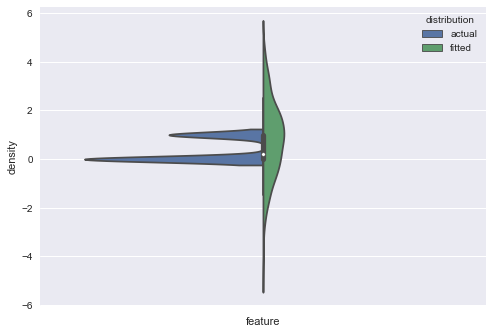

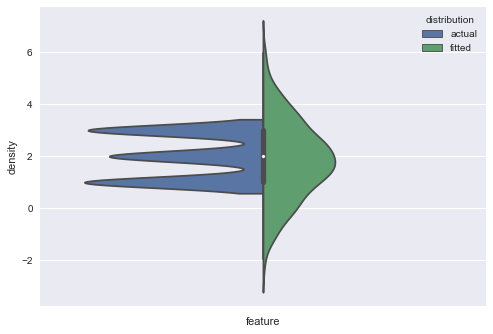

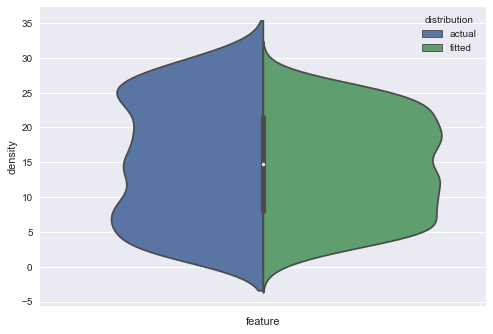

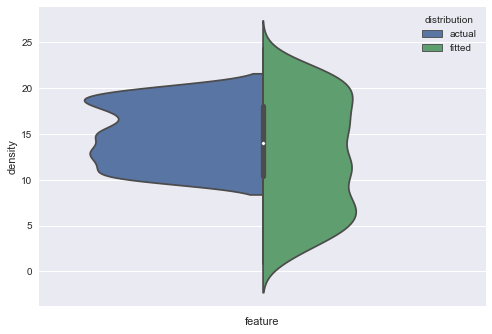

In [24]:
from visualisation.visualisation import Visualisation

y_hat = cgan.sample(X)
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [25]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 1.3455613889457259
JS: 0.061579323351224596
